# Sieci neuronowe 
Autor: Anna Dawi

Korekta: A. Kalinowski

Rozwiązanie: Zofia Hendrysiak

Dzisiaj pod lupę weźmiemy jeden z najpopularniejszych i wszechstronnych modeli uczenia maszynowego - sieci neuronowe. Skupimy się na dwóch zagadnieniach: jak znaleźć optymalną architekturę sieci oraz o arcyważnym problemie regularyzacji. Będziemy pracować na zbiorze MNIST, czyli zbiorze czarno-białych obrazków z ręcznie napisanymi cyframi.

## Przygotowanie środowiska programistycznego

By zapewnić powtarzalność wyników ustawiany ziarno generatora liczb losowych:
```
seed = 128
rng = np.random.RandomState(seed)
```

In [ ]:
import sys
import os
from termcolor import colored
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

import keras
from keras.datasets import mnist
from keras.utils import np_utils

import tensorflow as tf

seed = 128
rng = np.random.RandomState(seed)

def testModelOnMyDigits(model):    
    #Code created by M.Fila
    if not os.path.isdir("colab_freehands"):
        !git clone https://github.com/m-fila/colab_freehands.git

    from colab_freehands.canvas import Canvas  
    canvas = Canvas(line_width=2)
    example = (
        canvas.to_array(size=(20, 20), margin=(4, 4), dtype=np.float32, weighted=True) / 255
    )
    example_flatten = example.reshape( (-1))
    predictions = model(np.expand_dims(example_flatten, (0, -1)))
    plt.imshow(example, cmap="gray")
    plt.show()
    print(
        "Predicted class: {} ({:.0f}%)".format(
            np.argmax(predictions), np.max(predictions) * 100
        )
    )

## Import danych MNIST

Proszę:

* wczytać dane korzysatając z funkcji ```keras.datasets.mnist.load_data()```
* wypisać na ekran kształ danych uczących i testowych. Ile jest przykładów uczących i testowych? Jaką rozdzielczośc mają analizowane rysunki?
* korzystając z funkcji ```matplotlib.pyplot.imshow()``` narysować przykład numer 0 z danych uczących i wypisać jego etykietę

11501568/11490434 [==============================] - 0s 0us/step
Training data features: (60000, 28, 28)
Training data labels: (60000,)
Test data features: (10000, 28, 28)
Test data labels: (10000,)
Trainig data example number 0: label: 5



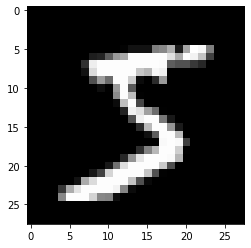

In [ ]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print(colored("Training data features:", "blue"), X_train.shape)
print(colored("Training data labels:", "blue"), Y_train.shape)

print(colored("Test data features:", "blue"), X_test.shape)
print(colored("Test data labels:", "blue"), Y_test.shape)

print(colored("Trainig data example number 0:", "blue"), "label:", Y_train[0])
print()

plt.imshow(X_train[0], cmap='gray');

## Wstępne przygotowanie danych (ang. preprocessing)

Dane które analizujemy mają postać dwuwymiartowych macierzy, ale sieci neuronowe które dziś trenujemy przyjmują na wejściu jednowymiarowe wektory.
Proszę:

* zmienić kształ danych wejścionych na jednowymiarowe macierze - operacja "spłaszczenia"
* wypisać kształ macierzy po spłaszeniu. Czy wymiar jest zgodny z oczekiwaniem?
* znormalizować wartości danych do zakresu **[0,1]** korzysatając z funkcji ```numpy.amax(...)```

In [ ]:
print("Training data shape before flattening:", X_train.shape)

X_train = X_train.reshape(X_train.shape[0],-1)
X_test = X_test.reshape(X_test.shape[0],-1)

print("Training data shape after flattening:",X_train.shape)

maxValue = np.amax(X_train)
print("Maximum value in training data:",maxValue)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 225
X_test /= 225

Training data shape before flattening: (60000, 28, 28)
Training data shape after flattening: (60000, 784)
Maximum value in training data: 255


## Zmiana reprezentacji etykiet

Etykiety zawierają numer klasy - cyfry. Łatwiejszą do analizy postacią jest reprezentacja za pomocą słowa bitowego o długości równej licznie klas.
W takim słowie wszystkie bity, oprócz jednego - wsazującego na daną klasę mają wartość **0**:

```
Original label encoding: 5 shape: (60000,)
One hot label encoding: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] shape: (60000, 10)

```

Takie kodowanie nazywa się "one hot encoding".

Proszę:

* korzystając z funkcji ```tensorflow.one_hot(...)``` zamienić etykiety na reprezentację "one hot encoding"
* wypisać na ekran orginalne i nowe kodowanie etykiety dla przykładu 0 ze zbioru uczącego

In [ ]:
print("Original label encoding:",Y_train[0], "shape:", Y_train.shape)
depth = 10

Y_train = tf.one_hot(Y_train, depth)
Y_test = tf.one_hot(Y_test, depth)

print("One hot label encoding for training data:", Y_train[0], "shape:", Y_train.shape)
print("One hot label encoding for test data:",Y_test[0], "shape:", Y_test.shape)

Original label encoding: 5 shape: (60000,)
One hot label encoding for training data: tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0. 0.], shape=(10,), dtype=float32) shape: (60000, 10)
One hot label encoding for test data: tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], shape=(10,), dtype=float32) shape: (10000, 10)


## Definicja architektury sieci neuronowej

Proszę zdefiniować sieć neuronową o rachiketurze w pełni połączonej (ang. fully connected). Sieć powinna mieć:
* warstwę wejściową
* 4 warstwy ukryte o 500 neuronach każda z funkcją aktywacji ```relu``
* wartę wyjściową z funkcją aktywacji ```sofmax```  


Proszę:

* przeanalizować funkcję ```getModel(nHidden, nNeurons, inputWidth, outputWidth)``` która tworzy model o zadanej liczbe wartw ukrytych ```nHidden``` z zadaną liczbą neuronów w każdej warstwie ```nNeurons``` przyjmujący na wejściu wektor o długości ```inputWidth```
* obliczyć samodzielnie liczbę parametrów pierwszej warsty ukrytej i porównać ją z wynikiem działania funkcji ```model.summary(...)```
* obejrzeć rysunek przedstawiający architekturę modelu, uzysdkany przy pomocy funkcji ```tf.keras.utils.plot_model(...)```

Number of parameters for the first hidden layer: 392500
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 500)               392500    
                                                                 
 dense_1 (Dense)             (None, 500)               250500    
                                                                 
 dense_2 (Dense)             (None, 500)               250500    
                                                                 
 dense_3 (Dense)             (None, 500)               250500    
                                                                 
 dense_4 (Dense)             (None, 500)               250500    
                                                                 
 dens

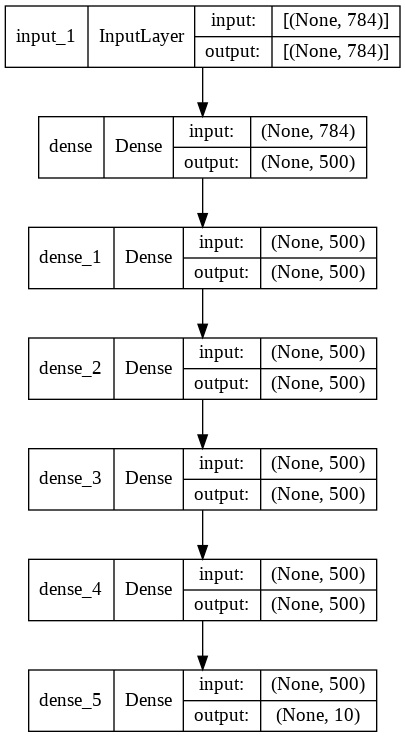

In [ ]:
def getModel(nNeurons, nHiddenLayers, inputWidth, outputWidth):
      
    inputs = tf.keras.Input(shape=(inputWidth,))
    x = inputs
    for iHidden in range(nHiddenLayers):   
        x = tf.keras.layers.Dense(nNeurons, activation=tf.nn.relu)(x)
  
    outputs = tf.keras.layers.Dense(outputWidth, activation=tf.nn.softmax)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

nNeurons = 500
nHiddenLayers = 5
inputWidth = 28*28
outputWidth = 10
model_basic = getModel(nNeurons, nHiddenLayers, inputWidth, outputWidth)

print(colored("Number of parameters for the first hidden layer:","blue"),inputWidth*nNeurons+nNeurons)

model_basic.summary()
tf.keras.utils.plot_model(model_basic, 'ML_model.png', show_shapes=True)

## Trenowanie modelu

Trenowanie modelu polega na znalezienu parametrów modelu dla których funkcja straty przyjmuje minimalną wartość. Problem ten w ogólności nie może być rozwiązany analiztycznie i minimalizacja jest przeprowadzana numerycznie. Standardowym wyborem algorytmu minimalizacji jest 
[adaptive momemtum estimation](https://arxiv.org/abs/1412.6980). W sytuaccji kiedy model ma za zadanie kategoryzację danych jako funkcję straty przyjmuje się zwykle entropię krzyżową (ang. crossentropy). W sytuacji kiedy klas jest więcej niż dwie trzeba użyć wariantu "categorical_crossentropy".


Trening jest prowadzony iteracyjnie. Każde przejście przez pełen zestaw danych jest **epoką**. Dane zwykle są podzielone na paczki **batch**.
Postęp treningu można monitorować używająć wybranej metryki na danych uczących i testowych. Zwykle używa się dokładności.

Proszę:

* przeprowadzić trening dla `10` epok z rozmiarem paczki wynoszącym `128`
* jako algorytm,u minimalizacji proszę użyć `adam`
* jako funkcji straty proszę użyć `categorical_crossentropy`
* jako metryki proszę użyć `accuracy`

**Uwaga**: po pierwszym treningu proszę pełączyć śrdowisko wykonawcze by używało karty graficznej "GPU": z menu na górze:
```
Środowisko wykonawcze -> Zmień typ środowiska wykonawczego
```
Oczekiwany efekt:
```
Epoch 1/10
469/469 [==============================] - 2s 3ms/step - loss: 0.2286 - accuracy: 0.9302 - val_loss: 0.1268 - val_accuracy: 0.9619

...

Epoch 10/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0233 - accuracy: 0.9930 - val_loss: 0.0861 - val_accuracy: 0.9803
```

Proszę:
* porównać wartości metryki na danych uczących i testowych. Jaki wniosek wynika z tego porównania?

In [ ]:
%time 

epochs = 15
batch_size = 128

model_basic_fit = model_basic.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs
Epoch 1/15
469/469 [==============================] - 5s 5ms/step - loss: 0.2301 - accuracy: 0.9295 - val_loss: 0.1182 - val_accuracy: 0.9640
Epoch 2/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0942 - accuracy: 0.9722 - val_loss: 0.0850 - val_accuracy: 0.9749
Epoch 3/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0691 - accuracy: 0.9793 - val_loss: 0.0846 - val_accuracy: 0.9745
Epoch 4/15
469/469 [==============================] - 2s 5ms/step - loss: 0.0522 - accuracy: 0.9844 - val_loss: 0.0951 - val_accuracy: 0.9738
Epoch 5/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0431 - accuracy: 0.9867 - val_loss: 0.0843 - val_accuracy: 0.9773
Epoch 6/15
469/469 [==============================] - 2s 5ms/step - loss: 0.0378 - accuracy: 0.9886 - val_loss: 0.0754 - val_accuracy: 0.9807
Epoch 7/15
469/469 [==============================] - 2s 5ms/step - loss: 0.0343 - a

## Analiza historii treningu

Proszę uzupełnić funkcję ```plotTrainingHistory(model)``` tak by tworzyła wykresy:

* na jednym wykresie wartości metryki w funkcji numeru epoki obliczone dla danych uczących i treningowych
* na drugim wykresie funkcji straty  w zależności od numeru epoki obliczone dla danych uczących i treningowych

Wartości potrzebnych parametrów są dostępne w obiekcie ```Model.history```

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
[0.9295333623886108, 0.9721500277519226, 0.9793499708175659, 0.984416663646698, 0.9867333173751831, 0.9886000156402588, 0.989799976348877, 0.9909499883651733, 0.992816686630249, 0.9928333163261414, 0.9942166805267334, 0.9937333464622498, 0.9942666888237, 0.9941999912261963, 0.9949833154678345]


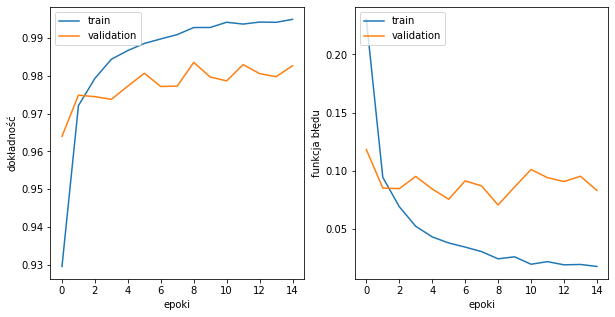

In [ ]:
print(model_basic_fit.history.keys())
history = model_basic_fit.history
print(history['accuracy'])

def plotTrainingHistory(model):

    fig, axes= plt.subplots(1,2,figsize=(10,5))
    history = model.history
    axes[0].plot(history['accuracy'])
    axes[0].plot(history['val_accuracy'])
    axes[0].set_ylabel("dokładność")
    axes[0].set_xlabel("epoki")
    axes[0].legend(['train', 'validation'], loc='upper left')

    axes[1].plot(history['loss'])
    axes[1].plot(history['val_loss'])
    axes[1].set_ylabel('funkcja błędu')
    axes[1].set_xlabel('epoki')
    axes[1].legend(['train', 'validation'], loc='upper left')
    
    
plotTrainingHistory(model_basic_fit)   

## Sprawdzenie modelu na własnych danych

Proszę uruchomić komórkę poniżej i sprawdzić jak model rozpoznaje własnoręcznie napisane cyfry

**Uwaga** ten fragment działa tylko w Google Colaboratory

Cloning into 'colab_freehands'...
remote: Enumerating objects: 28, done.
remote: Total 28 (delta 0), reused 0 (delta 0), pack-reused 28
Unpacking objects: 100% (28/28), done.


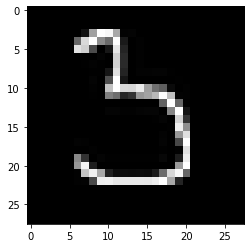

Predicted class: 3 (98%)


In [ ]:
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB: 
    testModelOnMyDigits(model_basic)

## Regularyzacja procesu treningu

Analiza historii uczenia i wartości metryk na zbiorahc uczącym i treninsgowym wskazuje, że uzyskany model nie generalizuje się dobrze - jego odpowiedź na dane których nie "widział" w czasie treningu jest gorsza niż na dane uczące. Jednym ze sposobów redukcji tego efektu jest **regularyzacja** modelu poprzez nałożeniu 
różnych ograqniczeń na proces uczenia to mogą być:

* zmiana liczby epok i zatrzymanie uczenia w chwili gdy metryka na zbiorze testowym się nie zmienia, lub pogarsza - ang. **early stopping**
* ograniczenia na wartości wag uzyskane przez dodawanie członów do funkcji straty kierujących prosec uczenia to wybranego obszaru wag, np. małych wartości wag - **L1 or L2 penalty term**
* losowe wyłączanie neuronów - ang. **dropout**

### Early stopping

Proszę:

* stworzyć model ```model_early_stop``` o tej samej architekturze co model ```model_basic```
* przeprowadzić trening z opcją "early_stop": ```callbacks = [tf.keras.keras.EarlyStopping(monitor='val_accuracy', patience=2)]``` Co oznacza parametr "cierpliwość"?
* narysować rysunki dla historii treningu

Czy moment przerwania treningu jest zgodny z oczekiwaniem?

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.11 µs
Epoch 1/15
469/469 [==============================] - 3s 5ms/step - loss: 0.2223 - accuracy: 0.9328 - val_loss: 0.1161 - val_accuracy: 0.9635
Epoch 2/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0952 - accuracy: 0.9720 - val_loss: 0.0912 - val_accuracy: 0.9726
Epoch 3/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0674 - accuracy: 0.9796 - val_loss: 0.0824 - val_accuracy: 0.9738
Epoch 4/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0528 - accuracy: 0.9836 - val_loss: 0.0977 - val_accuracy: 0.9753
Epoch 5/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0424 - accuracy: 0.9876 - val_loss: 0.1028 - val_accuracy: 0.9730
Epoch 6/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0362 - accuracy: 0.9889 - val_loss: 0.0829 - val_accuracy: 0.9793
Epoch 7/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0322 - a

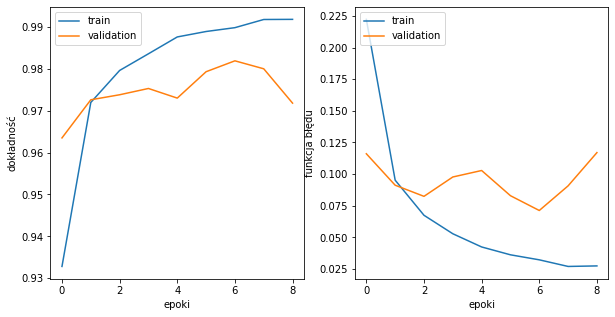

In [ ]:
%time

model_early_stop = getModel(nNeurons, nHiddenLayers, inputWidth, outputWidth)

model_early_stop_fit = model_early_stop.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test), 
                                    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

plotTrainingHistory(model_early_stop_fit) 

### Regularyzacja L2 i L1

Regularyzacje L1 i L2 prowadzą do uzyskania moeli które mają małe wartości wag. Efekty ten uzyskuje się przez dodanie członu "kary" ang. "penalty term" do funkcji straty:
 
\begin{equation}
L_{1} = \lambda \sum_{i} w_{i},~~
L_{2} = \lambda \sum_{i} w_{i}^{2}
\end{equation}

gdzie $w_{i}$ to wagi modelu, a $\lambda$ to parametr skalujący wielkość członu kary.

Proszę:

* stworzyć model ```model_L2``` o tej samej architekturze co model ```model_basic``` z regularyzacją L2 dla każdej warstwy. Efekt ten możne uzyskać na conajmniej dwa sposoby:
    * napisać nową funkcję ```getModelWithL2(...)``` z opcją regularyzacji L2 dla każdej warstwy: ```kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)```
    * dodać regularyzację dla warstw istniejącego modelu:
    
      ```
      layers = model_basic.layers
      ...
      layer.kernel_regularizer =  tf.keras.regularizers.l2(l2_lambda)
      ```
      W tym wypadku należy skompilowac model powtórnie:
      ```
      model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
      ```
* przeprowadzić trening z parametrami jak poprzednio
* narysować rysunki dla historii treningu

Epoch 1/15
469/469 [==============================] - 3s 5ms/step - loss: 1.1817 - accuracy: 0.9255 - val_loss: 0.6012 - val_accuracy: 0.9603
Epoch 2/15
469/469 [==============================] - 2s 5ms/step - loss: 0.4576 - accuracy: 0.9628 - val_loss: 0.3492 - val_accuracy: 0.9694
Epoch 3/15
469/469 [==============================] - 2s 5ms/step - loss: 0.3179 - accuracy: 0.9681 - val_loss: 0.2854 - val_accuracy: 0.9708
Epoch 4/15
469/469 [==============================] - 2s 4ms/step - loss: 0.2782 - accuracy: 0.9704 - val_loss: 0.2707 - val_accuracy: 0.9712
Epoch 5/15
469/469 [==============================] - 2s 5ms/step - loss: 0.2546 - accuracy: 0.9744 - val_loss: 0.2456 - val_accuracy: 0.9761
Epoch 6/15
469/469 [==============================] - 2s 5ms/step - loss: 0.2411 - accuracy: 0.9759 - val_loss: 0.2394 - val_accuracy: 0.9749
Epoch 7/15
469/469 [==============================] - 2s 5ms/step - loss: 0.2292 - accuracy: 0.9775 - val_loss: 0.2367 - val_accuracy: 0.9751


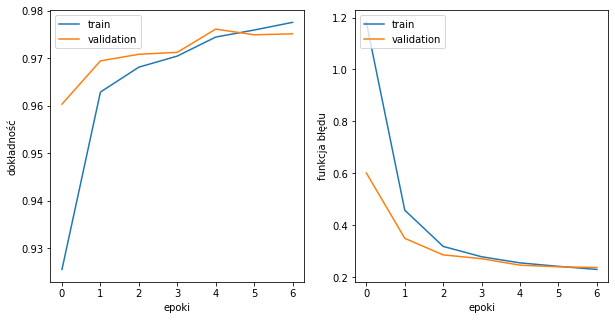

In [ ]:
from keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
l2_lambda = 0.001
layer = model_basic.layers
def model_L2(nNeurons, nHiddenLayers, inputWidth, outputWidth):
  inputs = tf.keras.Input(shape=(inputWidth,))
  x = inputs
  for iHidden in range(nHiddenLayers):   
    x = tf.keras.layers.Dense(nNeurons, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(l2_lambda))(x)
  outputs = tf.keras.layers.Dense(outputWidth, activation=tf.nn.softmax, kernel_regularizer=regularizers.l2(l2_lambda))(x)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

model_L2_fit = model_L2(nNeurons, nHiddenLayers, inputWidth, outputWidth).fit(X_train,  Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test), callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])
plotTrainingHistory(model_L2_fit)  


### Dropout

Opuszczanie neuronów (ang. dropout) polega na dezaktywacji losowych neutronów w czasie treningu. Dezaktywacja neuronów jesty uzyskiwane przez zerowanie wagi danwego neuronu względem następnej wartwy. Efekt ten uzyskuje się przez wstawienie dedykowanerj warstwy - "tf.keras.Dropout" po warstwie w której mają być dezaktywowane neurony.

Proszę:

* napisać funkcję ```getModelWithDropout(nNeurons, nHiddenLayers, inputWidth, outputWidth, dropout_rate)``` która tworzy model z warstawmi "Dropout" po każdej warsdtwie ukrytej
* stworzyć model ```model_droput``` o tej samej architekturze co model ```model_basic``` z warstwami "Dropout" po każdej warstwie ukrytej.
* wypisać na ekran architekturę modelu, używając funkcji ```model.summary()``` i sprawdzić czy struktura modelu jest zgodna z oczekiwaniem
* przeprowadzić trening z parametrami jak poprzednio
* narysować rysunki dla historii treningu

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_18 (Dense)            (None, 500)               392500    
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_19 (Dense)            (None, 500)               250500    
                                                                 
 dropout_1 (Dropout)         (None, 500)               0         
                                                                 
 dense_20 (Dense)            (None, 500)               250500    
                                                                 
 dropout_2 (Dropout)         (None, 500)               0   

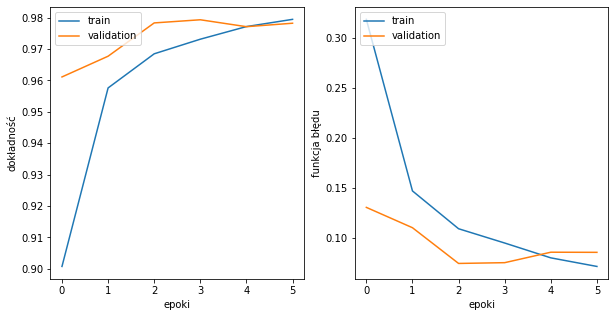

In [ ]:
l2_lambda = 0.001
layer = model_basic.layers
def getModelWithDropout(nNeurons, nHiddenLayers, inputWidth, outputWidth, dropout_rate):
  inputs = tf.keras.Input(shape=(inputWidth,))
  x = inputs
  for iHidden in range(nHiddenLayers):   
    x = tf.keras.layers.Dense(nNeurons, activation=tf.nn.relu)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
  outputs = tf.keras.layers.Dense(outputWidth, activation=tf.nn.softmax)(x)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

dropout_rate = 0.25
model_dropout = getModelWithDropout(nNeurons, nHiddenLayers, inputWidth, outputWidth, dropout_rate)
model_dropout.summary()

model_dropout_fit = model_dropout.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test), 
                                    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])
plotTrainingHistory(model_dropout_fit) 

### Połączenie metod L2 i dropout

Proszę:

* napisać funkcję ```getModelWithDropoutWithL2(nNeurons, nHiddenLayers, inputWidth, outputWidth, dropout_rate, l2_lambda)``` która tworzy model z warstawmi "Dropout" po każdej warstwie ukrytej, oraz regularyzacją typu L2 o tej samej architekturze co model ```model_basic```
* stworzyć model ```model_droput_L2```
* wypisać na ekran architekturę modelu, używając funkcji ```model.summary()``` i sprawdzić czy struktura modelu jest zgodna z oczekiwaniem
* przeprowadzić trening z parametrami jak poprzednio
* narysować rysunki dla historii treningu. 
* **proszę przeanalizować i skomentować wykresy**. Czy są one zgodne wykresami dla innych modeli?

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_24 (Dense)            (None, 500)               392500    
                                                                 
 dropout_5 (Dropout)         (None, 500)               0         
                                                                 
 dense_25 (Dense)            (None, 500)               250500    
                                                                 
 dropout_6 (Dropout)         (None, 500)               0         
                                                                 
 dense_26 (Dense)            (None, 500)               250500    
                                                                 
 dropout_7 (Dropout)         (None, 500)               0   

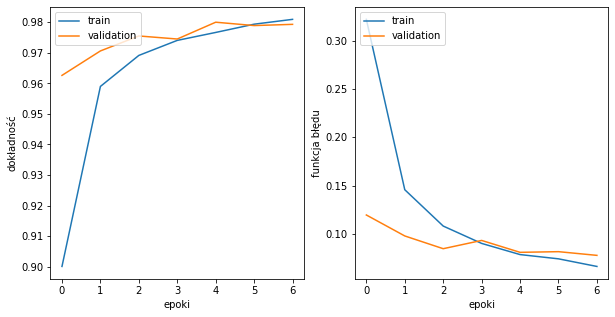

In [ ]:
def getModelWithDropoutWithL2(nNeurons, nHiddenLayers, inputWidth, outputWidth, dropout_rate, l2_lambda):
    inputs = tf.keras.Input(shape=(inputWidth,))
    x = inputs
    for iHidden in range(nHiddenLayers):   
        x = tf.keras.layers.Dense(nNeurons, activation=tf.nn.relu)(x)
        layer = tf.keras.layers.Dropout(rate=dropout_rate)
    outputs = tf.keras.layers.Dense(outputWidth, activation=tf.nn.softmax)(x)
    outputs = tf.keras.layers.Dense(outputWidth, activation=tf.nn.softmax)(layer)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model_dropoutL2 = getModelWithDropout(nNeurons, nHiddenLayers, inputWidth, outputWidth, dropout_rate)
model_dropoutL2.summary()

model_dropoutL2_fit = model_dropoutL2.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test), 
                                    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])
plotTrainingHistory(model_dropoutL2_fit) 

### Walidacja modelu

Który z wariantów jest optymalny? Czy mamy wystarczające dane by odpowiedzieć na to pytanie? 

Proszę:

* korzystająć z funkcji ```sklearn.model_selection.train_test_split(...)``` podzielić zbiór uczący na nowy uczący i walidacyjny w stosunku 7:3
* korzystając ze zbiorów uczącego i walidacyjnego wybrać optymalny model
* przeprowadzić trening modeli: `basic`, `early_stop`, `L2` i `L2_dropout` sprawdzając wydajność modelu na zbiorze walidacyjnym. W czasie treningu można zmiejszyć ilośc wypisywanych danych używając parametru ```verbose=2```
* wybrać model o najlepszej dokładności
* sprawdzić dokładność wybranego modelu na zbiorze testowym

In [ ]:
from sklearn.model_selection import train_test_split

#Reload the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
data_x = np.concatenate((x_train,x_test))
data_y = np.concatenate((y_train,y_test))
X_train, X_test, Y_train, Y_test = train_test_split(data_x, data_y, test_size=0.3)

#Check the shapes
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

#Flatten the data
X_train = X_train.reshape(X_train.shape[0],-1)
X_test = X_test.reshape(X_test.shape[0],-1)
print("Training data shape after flattening:",X_train.shape)

#Normalise the data
maxValue = np.amax(X_train)
print("Maximum value in training data:",maxValue)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 225
X_test /= 225

#Recode the labels
depth = 10

Y_train = tf.one_hot(tf.cast(tf.reshape(Y_train, -1), dtype=tf.int32), depth)
Y_test = tf.one_hot(tf.cast(tf.reshape(Y_test, -1), dtype=tf.int32), depth)

#Traing the models
model_basic_fit = model_basic.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test), verbose = 2)
model_early_stop_fit = model_basic.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test), verbose = 2)
modelL2_fit = model_basic.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test), verbose = 2)
model_dropoutL2_fit = model_basic.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test), verbose = 2)


print(colored("Best model:","blue"), "model_dropoutL2_fit")


print(colored("Best model metric on test data:","blue"))


(49000, 28, 28)
(49000,)
(21000, 28, 28)
(21000,)
Training data shape after flattening: (49000, 784)
Maximum value in training data: 255
Epoch 1/15
383/383 - 2s - loss: 0.0262 - accuracy: 0.9937 - val_loss: 0.0408 - val_accuracy: 0.9886 - 2s/epoch - 4ms/step
Epoch 2/15
383/383 - 2s - loss: 0.0173 - accuracy: 0.9956 - val_loss: 0.0417 - val_accuracy: 0.9908 - 2s/epoch - 4ms/step
Epoch 3/15
383/383 - 2s - loss: 0.0185 - accuracy: 0.9950 - val_loss: 0.0320 - val_accuracy: 0.9934 - 2s/epoch - 5ms/step
Epoch 4/15
383/383 - 2s - loss: 0.0118 - accuracy: 0.9968 - val_loss: 0.0289 - val_accuracy: 0.9936 - 2s/epoch - 5ms/step
Epoch 5/15
383/383 - 2s - loss: 0.0116 - accuracy: 0.9969 - val_loss: 0.0530 - val_accuracy: 0.9870 - 2s/epoch - 4ms/step
Epoch 6/15
383/383 - 2s - loss: 0.0115 - accuracy: 0.9967 - val_loss: 0.0599 - val_accuracy: 0.9855 - 2s/epoch - 4ms/step
Epoch 7/15
383/383 - 2s - loss: 0.0161 - accuracy: 0.9962 - val_loss: 0.0647 - val_accuracy: 0.9868 - 2s/epoch - 4ms/step
Epoch 8/1

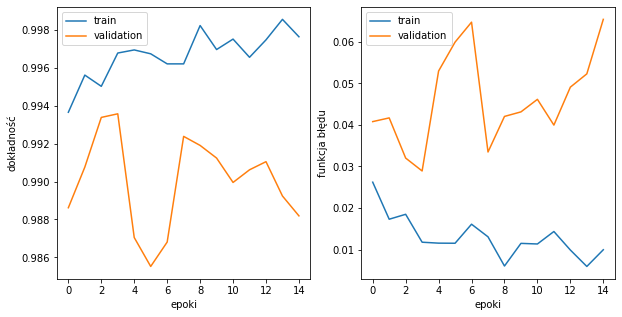

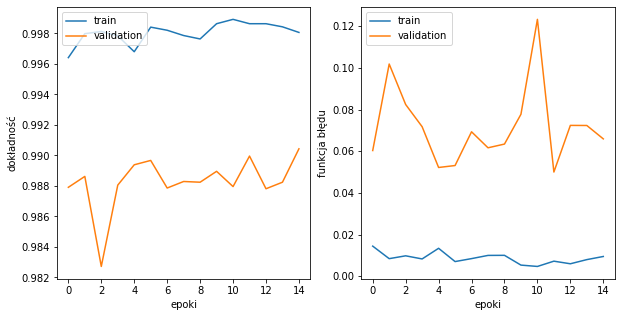

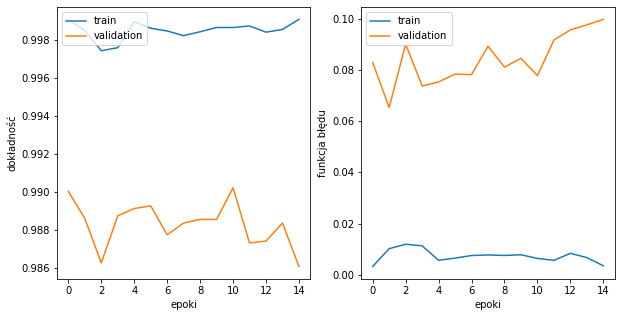

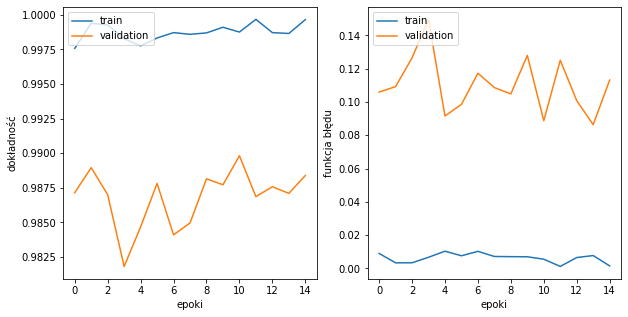

In [ ]:
plotTrainingHistory(model_basic_fit) 
plotTrainingHistory(model_early_stop_fit) 
plotTrainingHistory(modelL2_fit) 
plotTrainingHistory(model_dropoutL2_fit) 

## Zadanie domowe

### Warstawa spłaszczająca

Pierwsza operacja wstępnej analizy danych polegała na spłaszczeniu wielowymiarowje struktury do jednowymiarowego wektora. To jest częsta operacja i zdefiniowano dla niej odpowiednią warstwę (ang. layer).

Proszę:

* korzystająć z warstwy spłasznapisać funkcję ```getModelFinal(...)``` która tworzy wszystkim elementami (regularyzacja L2, dropout) który na wejściu przyjmuje oryginalne rysunki

Maximum value in training data: 255
Epoch 1/15
469/469 - 3s - loss: 0.3275 - accuracy: 0.8976 - val_loss: 0.1252 - val_accuracy: 0.9616 - 3s/epoch - 6ms/step
Epoch 2/15
469/469 - 2s - loss: 0.1420 - accuracy: 0.9596 - val_loss: 0.1049 - val_accuracy: 0.9679 - 2s/epoch - 4ms/step
Epoch 3/15
469/469 - 2s - loss: 0.1106 - accuracy: 0.9680 - val_loss: 0.0816 - val_accuracy: 0.9762 - 2s/epoch - 4ms/step
Epoch 4/15
469/469 - 2s - loss: 0.0907 - accuracy: 0.9730 - val_loss: 0.0862 - val_accuracy: 0.9768 - 2s/epoch - 4ms/step
Epoch 5/15
469/469 - 2s - loss: 0.0789 - accuracy: 0.9773 - val_loss: 0.1012 - val_accuracy: 0.9748 - 2s/epoch - 4ms/step
Epoch 6/15
469/469 - 2s - loss: 0.0702 - accuracy: 0.9802 - val_loss: 0.0708 - val_accuracy: 0.9805 - 2s/epoch - 4ms/step
Epoch 7/15
469/469 - 2s - loss: 0.0652 - accuracy: 0.9811 - val_loss: 0.0735 - val_accuracy: 0.9801 - 2s/epoch - 4ms/step
Epoch 8/15
469/469 - 2s - loss: 0.0584 - accuracy: 0.9831 - val_loss: 0.0800 - val_accuracy: 0.9787 - 2s/epoch

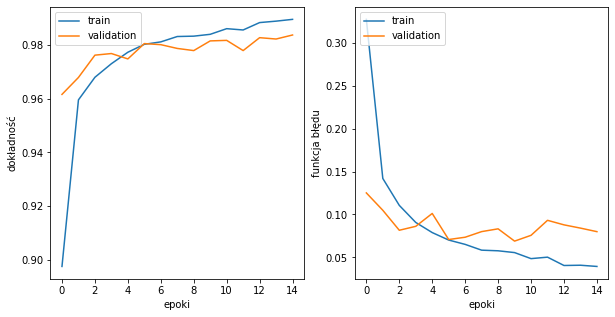

In [ ]:
def getModelFinal(nNeurons, nHiddenLayers, inputWidth, outputWidth, dropout_rate, l2_lambda):
  model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(inputWidth,inputWidth)),
  tf.keras.layers.Dense(nNeurons, activation='relu'),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(nNeurons, activation='relu'),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(nNeurons, activation='relu'),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(nNeurons, activation='relu'),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(nNeurons, activation='relu'),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(10, activation='softmax')
  ])
  model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
  )
  return model 

dropout_rate = 0.25
inputWidth = 28
model_final = getModelFinal(nNeurons, nHiddenLayers, inputWidth, outputWidth, dropout_rate, l2_lambda)

#Reload the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#Normalise the data
maxValue = np.amax(x_train)
print("Maximum value in training data:",maxValue)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 225
x_test /= 225

#Recode the labels
depth = 10

y_train = tf.one_hot(tf.cast(tf.reshape(y_train, -1), dtype=tf.int32), depth)
y_test = tf.one_hot(tf.cast(tf.reshape(y_test, -1), dtype=tf.int32), depth)


model_final = model_final.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), verbose=2)
plotTrainingHistory(model_final) 